In [1]:
import pyemu
import conda_scripts.load_datasets as lsd
import os
import pandas as pd
import numpy as np
import conda_scripts
import forward_run
import matplotlib.pyplot as plt
import conda_scripts.plot_help as ph
from conda_scripts import sv_budget
import matplotlib as mpl
import numpy as np
import flopy
import geopandas as gpd

loading forward_run.py from C:\GSP\sv\model\update_2024\scripts


In [2]:
workspace = 'pestaws_mango'

main = 'postprocess'
pstname =  'mango'
fold =  'mango'

out_folder = os.path.join(main, fold)
if not os.path.exists(out_folder):
    os.makedirs(out_folder, exist_ok =True)

In [3]:
ml = conda_scripts.sv_budget.load_sv_model.get_model(workspace)

C:\Users\arich\AppData\Local\mambaforge\envs\gis_py_10\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.


Loaded ibound from arrays inside model_arrays
date range is 1969-12-31 00:00:00 to 2018-09-30 00:00:00
the start date is 12/1/1969
126569.41734971055 53725.53016727514


C:\rich_py\conda_scripts\conda_scripts\utils\get_dates.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
C:\Users\arich\AppData\Local\mambaforge\envs\gis_py_10\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
C:\Users\arich\AppData\Local\mambaforge\envs\gis_py_10\lib\site-packages\flopy\utils\crs.py:122: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
C:\Users\arich\AppData\Local\mambaforge\envs\gis_py_10\lib\site-packages\flopy\utils\crs.py:122: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.


In [4]:
# sfr_file = os.path.join(workspace, 'drt.drt')
# with open(sfr_file, 'r') as sfr_read:
#     for i in range(7):
#         sfr_read.readline()

#     drt = flopy.modflow.ModflowDrt.load(sfr_read, ml)

In [5]:
ml.update_modelgrid()

In [6]:
ml.bas6.ibound

In [7]:
c_start =  np.concatenate([np.expand_dims(np.genfromtxt(os.path.join(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master",'init_heads', f"init_heads_lay{i+1}.dat"),
                                  dtype=float),axis  = 0)
                   for i in range(6)])

In [8]:
start = np.concatenate([np.expand_dims(np.genfromtxt(os.path.join(workspace,'init_heads', f"init_heads_lay{i+1}.dat"),
                                  dtype=float),axis  = 0)
                   for i in range(6)])

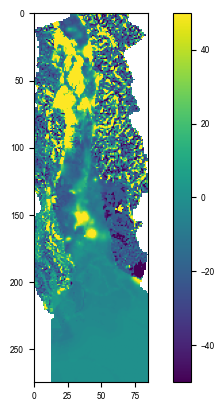

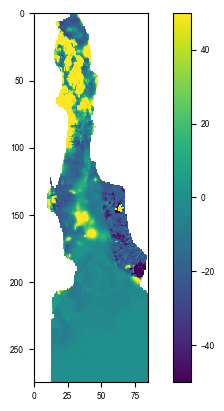

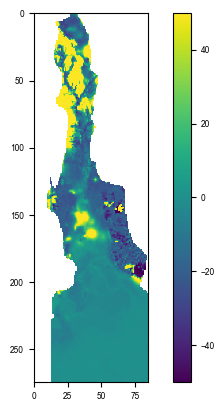

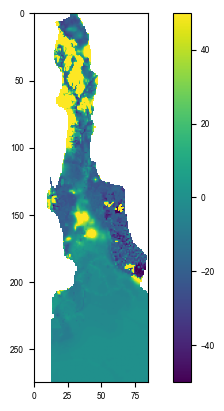

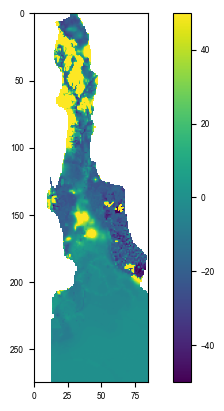

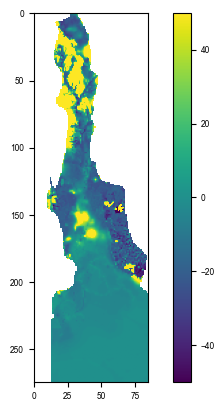

In [9]:

for i in range(6):
    plt.figure()
    ar = np.ma.array(c_start[i] - start[i], mask = ml.bas6.ibound.array[i]==0)
    plt.imshow(ar, vmin = -50, vmax = 50)
    plt.colorbar()

[<Axes: title={'center': ' SFR location stress period 1 layer 1'}>]

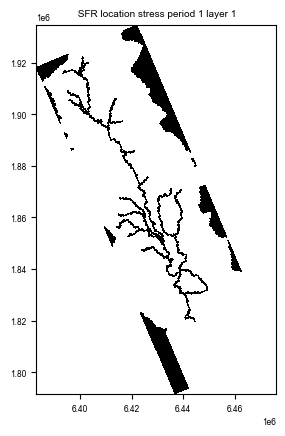

In [10]:
ml.sfr.plot(mflay = 0)

In [15]:
workspace

'pestaws_mango'

In [12]:
hdobj = flopy.utils.HeadFile(os.path.join(workspace, 'output',"sv_model_grid_6layers.hds"))
head = hdobj.get_data()

# head = np.ma.array(head, mask = head==-999.)

In [13]:

from matplotlib.lines import Line2D

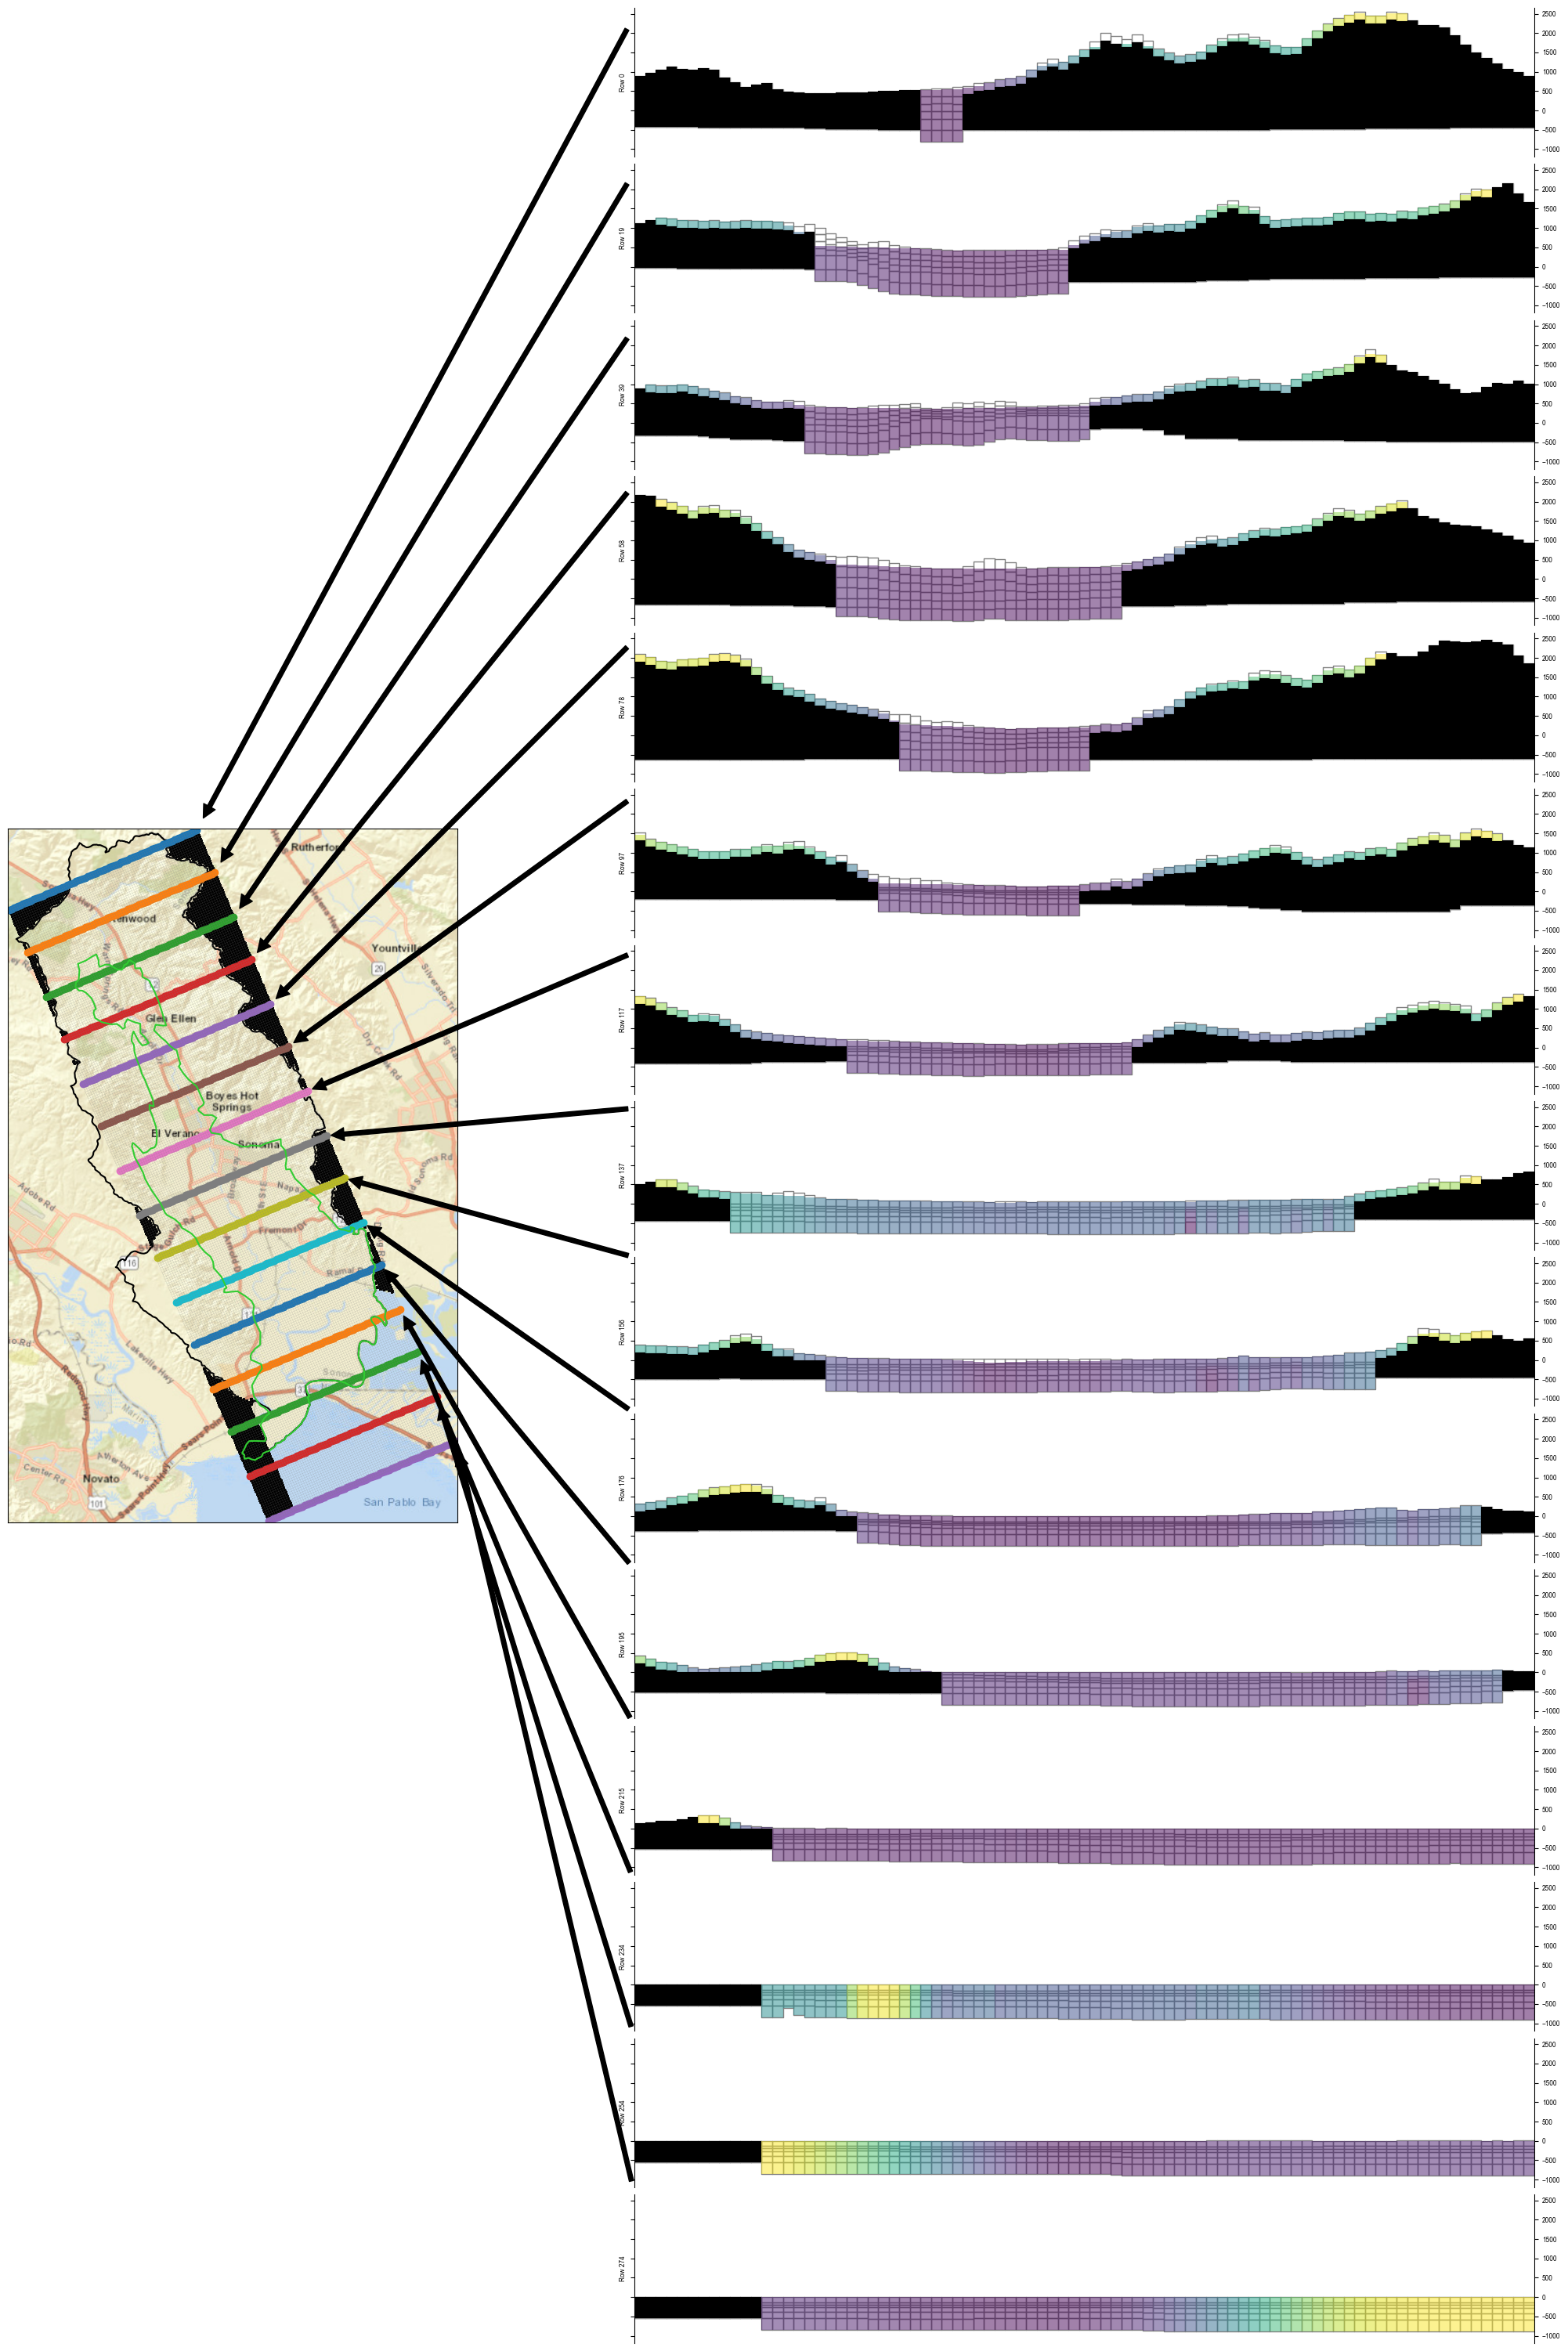

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(20, 30))

# Create gridspec layout with 1 row and 2 columns (one for left and one for right)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Create the left axes, which spans the entire height of the figure
ax3 = fig.add_subplot(gs[0])

sv_budget.sv_budget.sv_mod_map(simple = True,ax = ax3)
annotations = [child for child in ax3.get_children() if isinstance(child, mpl.text.Text)]
annotations[0].remove()
ax3.legend().remove()

M = flopy.plot.PlotMapView(modelgrid= ml.modelgrid, ax = ax3)
M.plot_grid(lw = .1, color = 'grey')

M.plot_ibound(ibound = ml.bas6.ibound.array[0])

nplots = 15
# Create a gridspec for the 7 axes on the right within the second column
gs_right = gridspec.GridSpecFromSubplotSpec(nplots, 1, subplot_spec=gs[1], hspace=0.05)

cnt = 0
for r in np.linspace(0,ml.nrow-1, nplots, dtype = int):
    # Create 7 right axes
    ax = fig.add_subplot(gs_right[cnt]) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    
    ax.tick_params(left=True, labelleft=False, bottom=False, labelbottom=False)
    ax.tick_params(right=True, labelright=True, bottom=False, labelbottom=False)

    xsect = flopy.plot.PlotCrossSection(model=ml, line={"Row": r})
    
    
    
    linecollection = xsect.plot_grid()
    # patches = xsect.plot_bc("drt", color="pink")
    
    pc = xsect.plot_array(head, head=head, masked_values =[-999.], alpha=0.5)
    # pc = xsect.plot_array(start, head=start, masked_values =[-999.], alpha=0.5)
    patches = xsect.plot_ibound()
    ax.set_ylabel(f"Row {r}")
    # t = ax.set_title(f"Row {r} Cross-Section with Boundary Conditions")

    #plot points on map
    ax3.scatter(ml.modelgrid.get_xcellcenters_for_layer(0)[r],
                ml.modelgrid.get_ycellcenters_for_layer(0)[r])

    x = ml.modelgrid.get_xcellcenters_for_layer(0)[r][-1]
    y = ml.modelgrid.get_ycellcenters_for_layer(0)[r][-1]

    
    # Annotating from the point in axes1 to the top left of axes2
    ax3.annotate(
        'Annotation Text',
        xy=(x, y),  # The data point in axes1
        xycoords='data',  # The coordinates are in data space of axes1
        xytext=(0, 1),  # Top left of axes2 (0,1 in axes coordinates)
        textcoords=ax.transAxes,  # Relative to axes2's coordinate system
        arrowprops=dict(facecolor='black', shrink=0.015),
        horizontalalignment='left',
        verticalalignment='top'
    )
    
    cnt +=1

plt.tight_layout()

plt.savefig(os.path.join(out_folder,'model_xsections_thick_new_start.png'), dpi = 250, bbox_inches = 'tight')


In [17]:
out_folder

'postprocess\\mango'

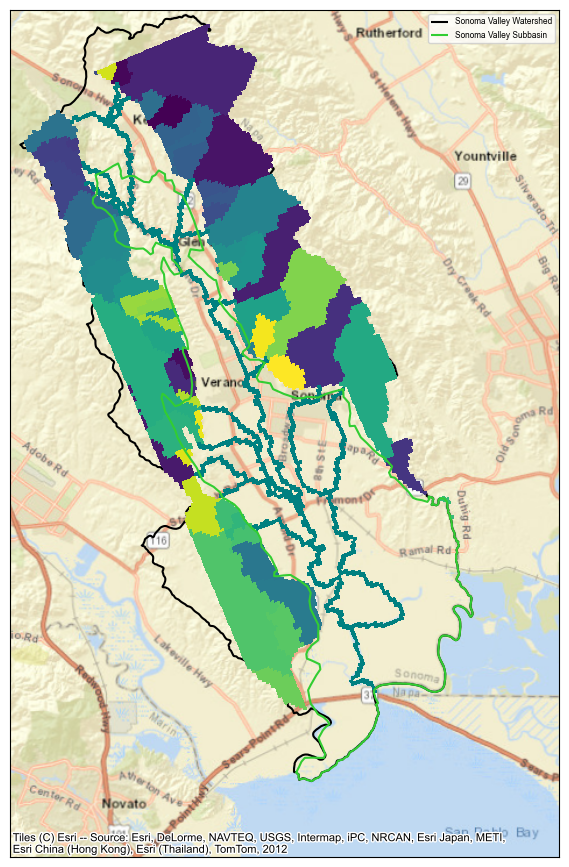

In [84]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(8.5, 11))

# Create gridspec layout with 1 row and 2 columns (one for left and one for right)
gs = gridspec.GridSpec(1, 1, width_ratios=[1])

# Create the left axes, which spans the entire height of the figure
ax3 = fig.add_subplot(gs[0])

sv_budget.sv_budget.sv_mod_map(simple = True,ax = ax3)

Map = flopy.plot.PlotMapView(model = ml, ax = ax3)
farms = os.path.join(workspace, 'fmp_input', 'farms','farm2016.dat')
farms = np.genfromtxt(farms, dtype = int)

subcat_farms = 81
farms = np.ma.array(farms, mask = farms<subcat_farms)
Map.plot_array(farms)
shp = conda_scripts.arich_functions.get_model_shp(ml.modelgrid)
shp = pd.merge(shp, conda_scripts.arich_functions.array2rc(farms).drop(columns = ['row', 'column']), on = ['i','j'])
Map.plot_bc('sfr')
# conda_scripts.plot_help.label_points_outside_map(shp.set_geometry(shp.geometry.centroid).drop_duplicates('value').rename(columns = {'value':'label'}).query(f"label>{subcat_farms}"),fig, ax3, 'label' )

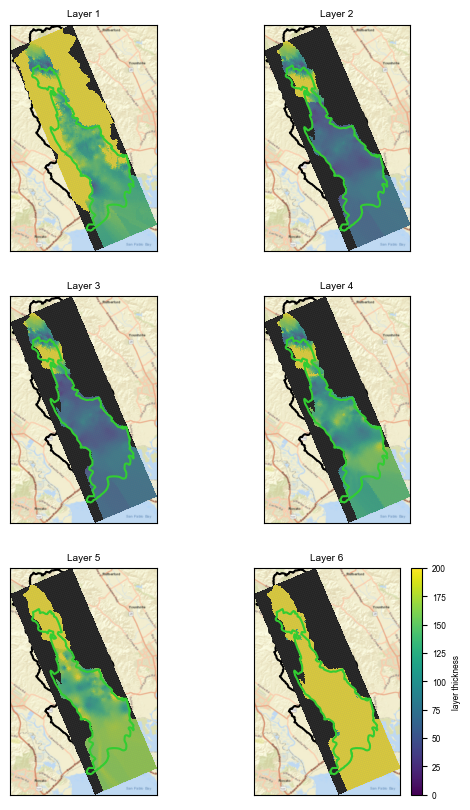

In [124]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
# fig = plt.figure()

fig, axs = plt.subplots(3,2, figsize=(6, 10))
axs = axs.ravel()
arrays = np.vstack([np.expand_dims(ml.dis.top.array,0), ml.dis.botm.array])

for lay in range(6):
    ax3 = axs[lay]
    sv_budget.sv_budget.sv_mod_map(simple = True,ax = ax3)
    annotations = [child for child in ax3.get_children() if isinstance(child, mpl.text.Text)]
    annotations[0].remove()
    ax3.legend().remove()
    
    M = flopy.plot.PlotMapView(modelgrid= ml.modelgrid, ax = ax3)
    M.plot_grid(lw = .1, color = 'grey')
    M.plot_ibound(ibound = ml.bas6.ibound.array[1])

    th = arrays[lay]-arrays[lay+1]

    ar = np.ma.array(ml.modelgrid.cell_thickness[lay],mask =ml.bas6.ibound.array[lay]==0)
    quadmesh = M.plot_array(ar, vmin = 0, vmax = 200)
    ax3.set_title(f"Layer {lay+1}")

# Add the colorbar to the axes
cbar = plt.colorbar(quadmesh, ax=ax3, label = 'layer thickness')
plt.savefig(os.path.join(out_folder,'layer thicknees.png'), dpi = 250, bbox_inches = 'tight')
# plt.savefig(os.path.join(out_folder,'model_xsections_thick_new_start.png'), dpi = 250, bbox_inches = 'tight')

# change the layer thicknesses here

In [101]:
arrays = np.vstack([np.expand_dims(ml.dis.top.array,0), ml.dis.botm.array])

In [24]:
c = (ml.bas6.ibound.array[0]==1) &   (ml.bas6.ibound.array[1]==0)


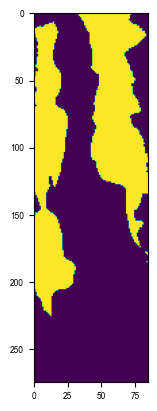

In [25]:
plt.imshow(c)

In [28]:
bot1 = np.copy(ml.dis.botm.array[0])

In [29]:
top = np.copy(ml.dis.top.array)
top

array([[ 8.9790e+02,  9.6760e+02,  1.0612e+03, ...,  1.0745e+03,
         9.9810e+02,  8.9410e+02],
       [ 9.4010e+02,  9.3780e+02,  9.7600e+02, ...,  1.0553e+03,
         9.6980e+02,  9.8400e+02],
       [ 1.0144e+03,  9.8700e+02,  1.0516e+03, ...,  1.1996e+03,
         1.0923e+03,  1.0581e+03],
       ...,
       [-3.6000e+00, -3.5000e+00, -3.6000e+00, ...,  9.0000e-01,
         4.0000e+00,  4.1000e+00],
       [-4.0000e+00, -4.0000e+00, -4.0000e+00, ...,  4.0000e+00,
         1.7000e+00,  3.4000e+00],
       [-4.4000e+00, -4.3000e+00, -4.4000e+00, ...,  1.0000e+00,
         1.3000e+00,  2.2000e+00]], dtype=float32)

In [30]:
bot1[c] = top[c]-200

In [58]:
np.savetxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\model_arrays\bot1.txt", bot1, fmt = "%.0f",)

In [32]:

np.savetxt(os.path.join(ml.model_ws,"model_arrays","bot1.txt"), bot1, fmt = "%.0f",)

In [ ]:
np.savetxt(r"C:\GSP\sv\model\update_2024\master\model_arrays\bot1.txt", bot1, fmt = "%.0f",)